# Cloudy

This is the official implementation for the paper: *"Light Transport-aware Diffusion Posterior Sampling for Single View Reconstruction of Volumes"*. The project is based on [**rendervous**](https://www.github.com/rendervous).


In [ ]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Let's start with required imports. Cloudy is based on rendervous and therefore in pytorch.

In [ ]:
import torch
import cloudy

The main object in cloudy is a `Pipeline`. This object is created bound to a specific work folder to save intermediate results of the workflow. Required tasks to train the generative model are:

- Training a decoder (`run_train_decoder`): From a folder with the grids of clouds dataset, a joint decoder is trained with a subset of the clouds.
- Encoding clouds (`run_encode_all`): Get the last decoder and use for encoding all clouds of the dataset with SGD.
- Enhancing clouds dataset (`run_enhance_all`): From encoded latents, applies transformations to the volumes and the latents, creating new latents with transformed volumes encoded.
- Compute Normalization Stats (`run_compute_stats`): From enhanced latents, computes the range for each feature channel centered in the mode.
- Train diffuser: Use the normalized latents to train a diffusion model to replicate the latents dataset.

After this process, required objects are the decoder (with an upsampler), the normalization stats and the diffuser. A version pre-trained can be automatically downloaded. 

In [1]:
pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()

Downloading...
From (original): https://drive.google.com/uc?id=1sc_UWXun6EuCTk5OUwkBzzUJf6_LVa6f
From (redirected): https://drive.google.com/uc?id=1sc_UWXun6EuCTk5OUwkBzzUJf6_LVa6f&confirm=t&uuid=c79c7f59-89d0-492d-a3b5-ccd544ec1ff1
To: /home/leonard/rendervous.project/cloudy_project/examples/test/pretrained.zip
100%|██████████| 261M/261M [00:02<00:00, 105MB/s]  


Without all intermediate outputs, the pipeline functionality is limited but main functions are present. Let's start generating a cloud.

In [2]:
latent = pipeline.generate_latent(samples=100)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Unconditional sampling DDIM: 100%|██████████| 101/101 [00:02<00:00, 44.51it/s]


The diffuser operates in the space of latent representations. To decode a grid we should get a representation (a model combining the upsampler with the latent decoder) and evaluate a regular grid of points. 

In [3]:
with torch.no_grad():
    grid = pipeline.from_latent_to_grid(latent, resolution=256)
    grid = grid * (grid >= 0.0).float()

A slice of the generated cloud can be visualized as follows.

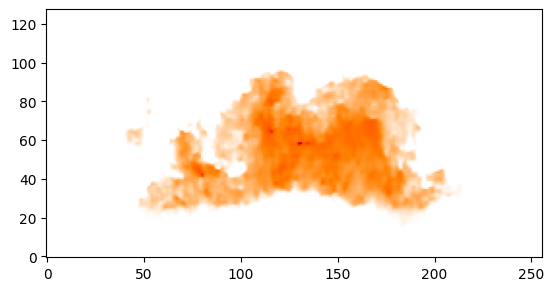

In [4]:
import matplotlib.pyplot as plt

plt.imshow(grid[:, :, grid.shape[2]//2, 0].cpu().T, cmap='gist_heat_r', vmin=0.0, vmax=0.6)
plt.gca().invert_yaxis()
plt.show()

**Cloudy** includes some tools for rendering and modeling. To render the volume as a cloud we need a set of camera poses, and environment, the volume grid of the densities, and other physical parameters of the cloud.

stdin


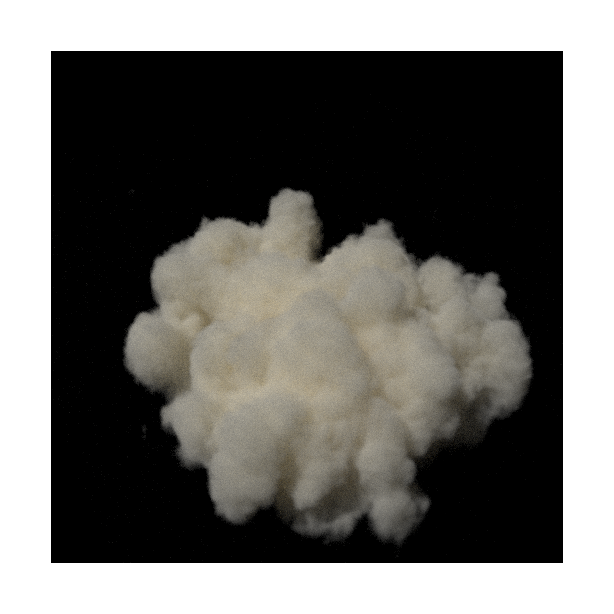

In [5]:
with torch.no_grad():
    camera_poses = cloudy.camera_poses((1.7, 1.5, -1.0))
    environment = torch.zeros(64, 128, 3, device='cuda')
    environment[10,0] = 1600
    im = cloudy.scattered(grid * 300, 
                          camera_poses=camera_poses,
                          scattering_albedo=(0.99, 0.98, 0.94),
                          environment=environment,
                          phase_g=0.0,
                          majorant=grid.max()*300,
                          # kwargs
                          width=512, 
                          height=512,
                          jittered=True,
                          samples=128
                          )
    plt.figure(figsize=(1, 1), dpi=512)
    plt.imshow(im[0].cpu() ** (1.0/2.2))
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.tight_layout(pad=0.0)
    plt.show()

In [6]:
import numpy as np
from tqdm import tqdm

with torch.no_grad():
    frames = torch.zeros(100, 512, 512, 3)
    for f in tqdm(range(len(frames)), desc="Generating video"):
        alpha = f/(len(frames) - 1)
        camera_poses = cloudy.camera_poses((np.cos(alpha*6.28)*2.7, np.sin(alpha*6.28), np.sin(alpha*6.28)*2.7))
        im = cloudy.scattered(grid * 300, 
                          camera_poses=camera_poses,
                          scattering_albedo=(0.99, 0.98, 0.94),
                          environment=environment,
                          phase_g=0.0,
                          majorant=grid.max()*300,
                          # kwargs
                          width=512, 
                          height=512,
                          jittered=True,
                          samples=128
                          )[0]
        frames[f] = torch.flip(im, dims=[0])
    cloudy.save_video(frames, 'generated_cloud.webp')

Generating video: 100%|██████████| 100/100 [06:38<00:00,  3.98s/it]


In [54]:
from IPython.display import *
Image(url='./generated_cloud.webp')